# CNN

## 0. Import libraries

In [75]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import sys
import time

import tensorflow as tf 
import keras

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split

## 1. Load dataset

In [76]:
d_pack = pd.read_csv('/home/sbml/cgan/230306_data/padding/pack_preprocessed.csv')[['resized_scaled','soh']]
d_pack_n = pd.read_csv('/home/sbml/cgan/230306_data/padding/pack_noise_preprocessed.csv')[['resized_scaled','soh']]
d_module = pd.read_csv('/home/sbml/cgan/230306_data/padding/module_preprocessed.csv')[['resized_scaled','soh']]

In [77]:
d_pack = pd.concat([d_pack, d_pack_n])
d_pack

,resized_scaled,soh
0,"[[0, 255, 123], [43, 250, 125], [63, 248, 126]...",1.000000
1,"[[36, 237, 129], [67, 255, 130], [80, 253, 131...",1.004347
2,"[[35, 206, 126], [67, 255, 128], [80, 253, 129...",0.998310
3,"[[38, 247, 129], [69, 255, 130], [82, 253, 131...",1.003081
4,"[[38, 253, 129], [69, 255, 130], [83, 253, 131...",1.002356
...,...,...
1745,"[[45, 199, 126], [77, 255, 130], [91, 254, 131...",0.908688
1746,"[[43, 197, 128], [77, 256, 128], [90, 253, 131...",0.908688
1747,"[[44, 197, 127], [78, 256, 128], [90, 253, 131...",0.908688
1748,"[[44, 198, 126], [78, 256, 129], [89, 254, 129...",0.908688


In [126]:
X = [eval(i) for i in d_pack['resized_scaled'].tolist()]
X = np.array(X)
y = np.array(d_pack['soh'].tolist()) 

In [127]:
X_module = [eval(i) for i in d_module['resized_scaled'].tolist()]
X_module = np.array(X_module)
y_module = np.array(d_module['soh'].tolist()) 

In [128]:
label = y
label_l = []
for cnt in range(len(label)):
    i = label[cnt]
    if i>=1.0 : 
        lab = '1~'
        num = 0
    elif 0.98<=i<1.0 :
        lab = '0.98~1'
        num = 1
    elif 0.96<=i<0.98 :
        lab = '0.96~0.98'
        num = 2
    elif 0.94<=i<0.96 :
        lab = '0.94~0.96'
        num = 3
    elif 0.92<=i<0.94 :
        lab = '0.92~0.94'
        num = 4
    elif 0.90<=i<0.92 :
        lab = '0.90~0.92'
        num = 5
        
    label_l.append(num)

## 2. CNN regression

In [129]:
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3)
for train_idx, test_idx in sss.split(X, np.array(label_l)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = np.array(y)[train_idx], np.array(y)[test_idx]
    y_valid = np.array(label_l)[test_idx]

In [130]:
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3)
for train_idx, test_idx1 in sss.split(X_test, y_valid):
    X_valid, X_test_f = X_test[train_idx], X_test[test_idx1]
    y_valid, y_test_f = np.array(y_test)[train_idx], np.array(y_test)[test_idx1]
X_valid.shape

(404, 256, 3)

In [131]:
X_train = X_train
X_valid = X_valid
X_test = X_test_f

y_test = y_test_f

In [132]:
rows = len(X[0])
cols = 3
batch_size = 64
input_shape = (rows, cols, 1)
x_train = X_train.reshape(X_train.shape[0], rows, cols, 1)
x_test = X_test.reshape(X_test.shape[0], rows, cols, 1)
x_valid = X_valid.reshape(X_valid.shape[0], rows, cols, 1)

x_train = x_train.astype('float32') /255.0
x_test = x_test.astype('float32')/255.0
x_valid = x_valid.astype('float32')/255.0

In [133]:
X_module = X_module.reshape(X_module.shape[0], rows, cols, 1)
X_module = X_module.astype('float32') /255.0

In [134]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (2,2), strides = (1,1), padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(64, kernel_size = (2,2), strides = (1,1), padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2), strides = (1,1)))
model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 256, 3, 32)        160       
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 3, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 255, 2, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 32640)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                2089024   
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                      

In [135]:
start = time.time()
epochs = 50
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
hist = model.fit(x_train, y_train, epochs = epochs, verbose = 1, validation_data = (x_valid, y_valid))
score = model.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
end = time.time()

print('Training Time: ' + str(end-start))

Epoch 1/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 6.6734e-05 - val_mse: 6.6734e-05
Epoch 2/50
43/43 [==============================] - 0s 3ms/step - loss: 9.5820e-05 - mse: 9.5820e-05 - val_loss: 4.2665e-05 - val_mse: 4.2665e-05
Epoch 3/50
43/43 [==============================] - 0s 3ms/step - loss: 3.2319e-05 - mse: 3.2319e-05 - val_loss: 4.6471e-05 - val_mse: 4.6471e-05
Epoch 4/50
43/43 [==============================] - 0s 3ms/step - loss: 3.0480e-05 - mse: 3.0480e-05 - val_loss: 2.5878e-05 - val_mse: 2.5878e-05
Epoch 5/50
43/43 [==============================] - 0s 3ms/step - loss: 2.9410e-05 - mse: 2.9410e-05 - val_loss: 2.4700e-05 - val_mse: 2.4700e-05
Epoch 6/50
43/43 [==============================] - 0s 3ms/step - loss: 2.9844e-05 - mse: 2.9844e-05 - val_loss: 6.7727e-05 - val_mse: 6.7727e-05
Epoch 7/50
43/43 [==============================] - 0s 3ms/step - loss: 3.8429e-05 - mse: 3.8429e-05 - val_loss: 6.1010e-05 - val_ms

Text(0.5, 1.0, 'epoch40_loss')

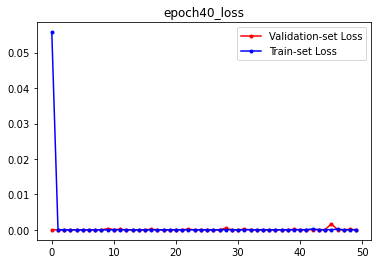

In [136]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']
x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend()
plt.title('epoch40_loss')
#plt.savefig('/home/sbml/cgan/230306_data/cnn_loss.svg')

In [137]:
predict = model.predict(x_test, verbose = 0)

predicted SOH:  [0.93696946] , Answer SOH:  0.9371419382254752
predicted SOH:  [0.98897946] , Answer SOH:  0.9879850257521536
predicted SOH:  [0.9551922] , Answer SOH:  0.9552820877703224
predicted SOH:  [0.957603] , Answer SOH:  0.9610730645911436
predicted SOH:  [0.97247916] , Answer SOH:  0.9680049878224272
predicted SOH:  [1.0063509] , Answer SOH:  1.0023555602272525
predicted SOH:  [0.96244] , Answer SOH:  0.9609445958220808
predicted SOH:  [0.9239038] , Answer SOH:  0.9192542343037728
predicted SOH:  [0.97109175] , Answer SOH:  0.9675836461952236
predicted SOH:  [0.9638384] , Answer SOH:  0.9632363708561972
predicted SOH:  [0.91978705] , Answer SOH:  0.9192461488567693
predicted SOH:  [0.9912085] , Answer SOH:  0.9920313427861208
predicted SOH:  [0.91822493] , Answer SOH:  0.9137480448940272
predicted SOH:  [0.96227294] , Answer SOH:  0.9605070833008678
predicted SOH:  [0.9182005] , Answer SOH:  0.9168492630115664
predicted SOH:  [0.9261228] , Answer SOH:  0.9224596648493348
pred

(0.87, 1.02)

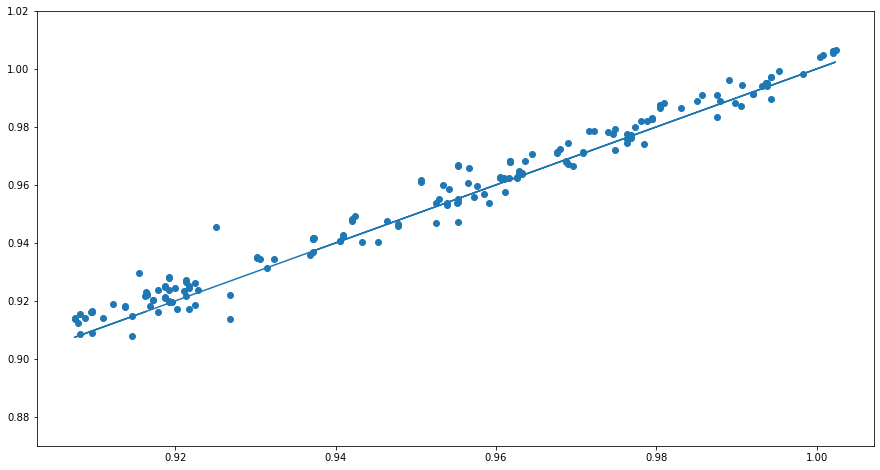

In [138]:
for i in range(len(predict)):
    print('predicted SOH: ' , predict[i],',' , 'Answer SOH: '  , y_test[i])


plt.figure(figsize = (15,8))
plt.plot(y_test, y_test)
plt.scatter(y_test, predict)
plt.ylim(0.87, 1.02)

## 3. Applied to module data

In [139]:
m_predict = model.predict(X_module, verbose = 0)

In [140]:
r2 = metrics.r2_score(y_module, m_predict)
rmse = metrics.mean_squared_error(y_module, m_predict)**0.5
mse = metrics.mean_squared_error(y_module, m_predict)
mae = metrics.mean_absolute_error(y_module, m_predict)
mape = metrics.mean_absolute_percentage_error(y_module,m_predict)

In [141]:
print(rmse)

0.005690881294429828
